Using Xlense from FieldLensing
==========

Load modules
----------

In [1]:
using FFTW
FFTW.set_num_threads(5)

using BenchmarkTools
using LBblocks
using Spectra
using XFields
using FieldLensing
using FFTransforms
using PyPlot

Set fourier grid parameters
----------

In [2]:
trn = @sblock let θpix′ = 2.5, nside = 512
    θpix = deg2rad(θpix′/60)
    period = nside * θpix
    𝕨 = r𝕎32(nside, period) ⊗ 𝕎(nside, period)
    ordinary_scale(𝕨)*𝕨
end

FFTransforms.𝕎{Float32,2,Float64,Float64}((512, 512), (true, true), 8.416904185929444e-8, (0.37233690709212364, 0.37233690709212364))

Compute the spectral matrices which mimic CMB tempurature and lesing potential
------------------------------

In [3]:
Ct, Cϕ = @sblock let trn
    l   = wavenum(trn)
    #cTl = Spectra.cTl_approx.(l)
    cTl = Spectra.cTl_besselj_approx.(l)
    #cTl = Spectra.cTl_matern_cov_approx.(l)
    cϕl = Spectra.cϕl_approx.(l)

    Ct  = DiagOp(Xfourier(trn, cTl))
    Cϕ  = DiagOp(Xfourier(trn, cϕl))

    Ct, Cϕ
end;

Visualize how close the fluctuations look.
---------------

In [4]:
T, ϕ = @sblock let trn, Ct, Cϕ
    zTx = randn(eltype_in(trn),size_in(trn)) ./ √Ωx(trn)
    zϕx = randn(eltype_in(trn),size_in(trn)) ./ √Ωx(trn)

    T = √Ct * Xmap(trn, zTx)
    ϕ = √Cϕ * Xmap(trn, zϕx)

    # extra scale factor for larger lense
    sc = 1.5

    T, sc * ϕ
end;

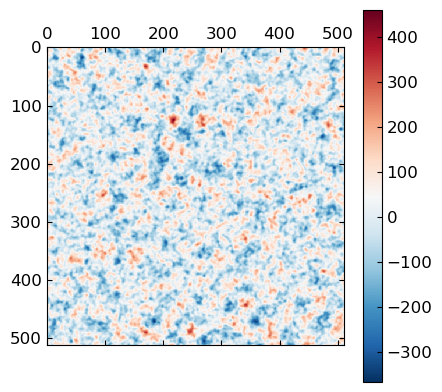

In [5]:
T[:] |> matshow; colorbar(); gcf()

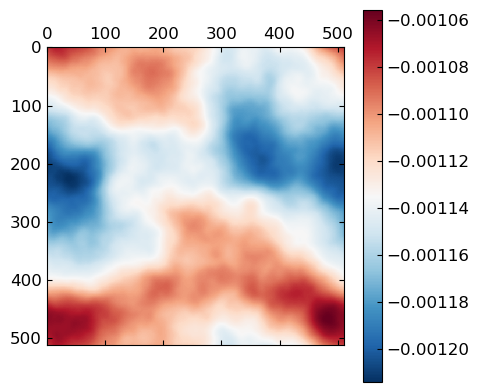

In [6]:
ϕ[:] |> matshow; colorbar(); gcf()

Construct lense and adjoint lense
---------------

Start by defining the gradient operator and use it to compute the lensing displacements

In [7]:
∇ = @sblock let trn
    k = fullfreq(trn)
    ik1 = Xfourier(trn, im .* k[1]) |> DiagOp
    ik2 = Xfourier(trn, im .* k[2]) |> DiagOp
    (ik1, ik2)
end;

In [8]:
vϕ = (∇[1] * ϕ, ∇[2] * ϕ)

(XFields.Xmap{FFTransforms.𝕎{Float32,2,Float64,Float64},Float32,Complex{Float32},2}(FFTransforms.𝕎{Float32,2,Float64,Float64}((512, 512), (true, true), 8.416904185929444e-8, (0.37233690709212364, 0.37233690709212364)), Float32[-0.0009325091 -0.00089674 … -0.00097566796 -0.0009564556; -0.00091315334 -0.00087070407 … -0.00096167077 -0.00094092655; … ; -0.00090266333 -0.00087413547 … -0.00095127756 -0.0009278103; -0.00092636206 -0.0008960128 … -0.0009724597 -0.00094925775]), XFields.Xmap{FFTransforms.𝕎{Float32,2,Float64,Float64},Float32,Complex{Float32},2}(FFTransforms.𝕎{Float32,2,Float64,Float64}((512, 512), (true, true), 8.416904185929444e-8, (0.37233690709212364, 0.37233690709212364)), Float32[0.0004989478 0.0005750512 … 0.000377938 0.00043258857; 0.0005302808 0.00062289496 … 0.00039540444 0.00045402852; … ; 0.00044675524 0.00050303136 … 0.0003332621 0.00038785907; 0.00047253928 0.00053580356 … 0.0003575389 0.00041105069]))

Now construct the lensing and adjoint lensing operator

In [9]:
L, Lʰ = @sblock let trn, vϕ, nsteps=16
    t₀ = 0
    t₁ = 1
    nsteps = 16
    L  = FieldLensing.Xlense(trn, vϕ, t₀, t₁, nsteps)
    L, L'
end;

Lense the field
---------------

Forward lensing field

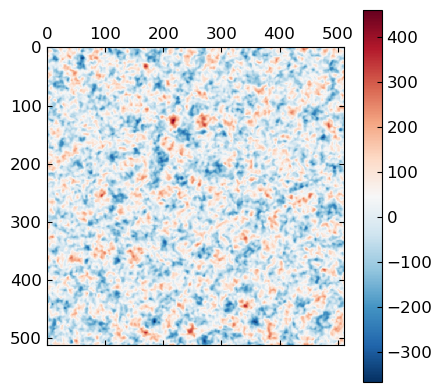

In [10]:
lenT1 = L * T
lenT1[:] |> matshow; colorbar(); gcf()

Difference between lensed and un-lensed

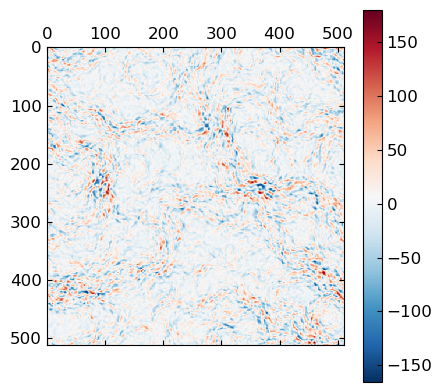

In [11]:
(T - lenT1)[:] |> matshow; colorbar(); gcf()

Invert the lense and compare

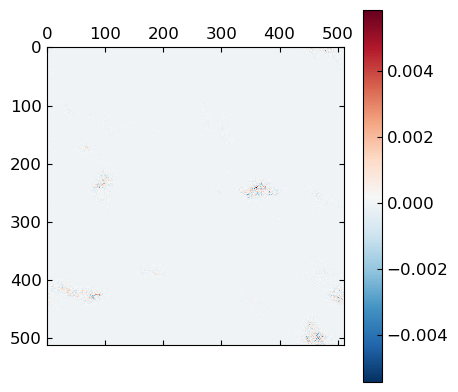

In [12]:
T1 = L \ lenT1
(T - T1)[:] |> matshow; colorbar(); gcf()

adjoint Lense the field
---------------

Forward adjoint lensing field

In [13]:
lenʰT1 = Lʰ * T

XFields.Xmap{FFTransforms.𝕎{Float32,2,Float64,Float64},Float32,Complex{Float32},2}(FFTransforms.𝕎{Float32,2,Float64,Float64}((512, 512), (true, true), 8.416904185929444e-8, (0.37233690709212364, 0.37233690709212364)), Float32[14.286316 19.379082 … 3.026997 6.7290106; 31.024946 35.96323 … 20.923555 24.42292; … ; -42.588165 -32.477596 … -40.060616 -44.78651; -15.989683 -5.982211 … -24.1112 -23.338102])

Difference between adjoint lensing and un-lensed

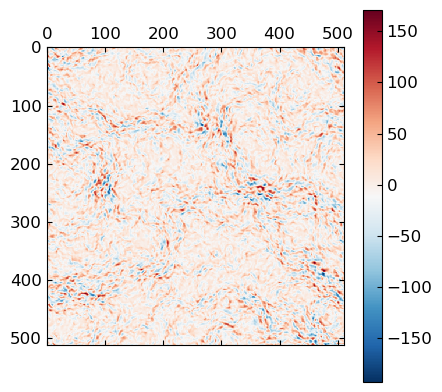

In [14]:
(T - lenʰT1)[:] |> matshow; colorbar(); gcf()

Invert the lense and compare

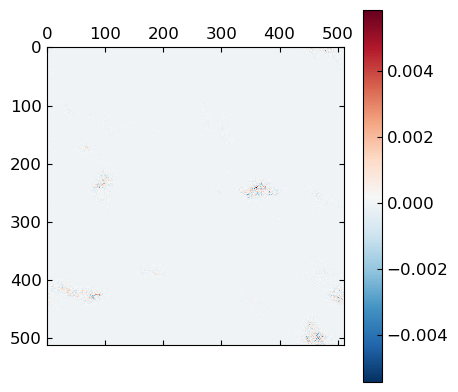

In [15]:
ʰT1 = Lʰ \ lenʰT1
(T - T1)[:] |> matshow; colorbar(); gcf()

Finally some benchmarks
----------------

In [16]:
@benchmark $L * $T

BenchmarkTools.Trial: 
  memory estimate:  37.28 MiB
  allocs estimate:  2331
  --------------
  minimum time:     111.104 ms (0.62% GC)
  median time:      112.711 ms (0.62% GC)
  mean time:        113.315 ms (0.59% GC)
  maximum time:     121.673 ms (0.59% GC)
  --------------
  samples:          45
  evals/sample:     1

In [17]:
@benchmark $Lʰ * $T

BenchmarkTools.Trial: 
  memory estimate:  37.28 MiB
  allocs estimate:  2331
  --------------
  minimum time:     117.030 ms (0.00% GC)
  median time:      119.809 ms (0.60% GC)
  mean time:        120.299 ms (0.72% GC)
  maximum time:     133.344 ms (0.80% GC)
  --------------
  samples:          42
  evals/sample:     1